In [1]:
import re
import pandas as pd

# Path to the log file for expected
log_path = "my_program_output.log"
# path to the log file for particular
log_path2 = "my_program_output_particular.log"
log_path3 = "my_program_output_particular_v2.log"

In [2]:
def log_file_to_dfs(log_path, name):

    # Regular expression pattern to capture the relevant data
    pattern = (
        r"Running for W = (\d+) and K = (\d+).*?"
        r"Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?:(\d+):)?(\d+):(\d+(?:\.\d+)?).*?"
        r"Maximum resident set size \(kbytes\): (\d+)"
    )

    # Dictionaries to store the time and memory data (W, K) -> value
    time_data = {}
    memory_data = {}

    # Read the log file
    with open(log_path, "r") as file:
        log_data = file.read()

    # Find all matches and parse the values
    matches = re.finditer(pattern, log_data, re.DOTALL)
    for match in matches:
        w = int(match.group(1))
        k = int(match.group(2))
        hours = int(match.group(3) or 0)
        minutes = int(match.group(4))
        seconds = float(match.group(5))
        max_memory_kb = int(match.group(6))

        # Convert time to total seconds and memory to MB
        total_seconds = hours * 3600 + minutes * 60 + seconds
        max_memory_mb = max_memory_kb / 1024

        # Store the results in their respective dictionaries
        time_data[(w, k)] = total_seconds
        memory_data[(w, k)] = max_memory_mb

    # Extract unique W and K values for creating the DataFrames
    ws = sorted(set(w for w, k in time_data))
    ks = sorted(set(k for w, k in time_data))

    # Create 2D DataFrames for time and memory
    time_df = pd.DataFrame(index=ws, columns=ks)
    memory_df = pd.DataFrame(index=ws, columns=ks)

    # Populate the DataFrames with the extracted values
    for (w, k), time in time_data.items():
        time_df.loc[w, k] = time

    for (w, k), memory in memory_data.items():
        memory_df.loc[w, k] = memory

    # Add "W/K" in the corner by renaming the index and columns
    time_df.index.name = "W/K"
    memory_df.index.name = "W/K"

    # Save the DataFrames to CSV files
    time_df.to_csv(f"time_data_{name}.csv")
    memory_df.to_csv(f"memory_data_{name}.csv")

    # Display the DataFrames
    print("Time Data (s):")
    print(time_df)
    print("\nMemory Data (MB):")
    print(memory_df)

    return time_df, memory_df


time_df, memory_df = log_file_to_dfs(log_path, 'expected')
time_df2, memory_df2 = log_file_to_dfs(log_path2, 'particular')
time_df3, memory_df3 = log_file_to_dfs(log_path3, 'particular_v2')


Time Data (s):
       3     4      5      6       7       8       9       10       11  \
W/K                                                                      
3    0.09  0.09   0.11   0.15    0.32    0.46     0.8    1.79     3.19   
4    0.06  0.05   0.07   0.11     0.2    0.35    0.64    1.28     2.79   
5    0.11  0.06   0.07   0.12    0.17    0.33    0.65     1.6     2.62   
6    0.07  0.06   0.11   0.17    0.31    0.68    1.14    1.98     5.05   
7    0.07  0.08   0.14   0.24    0.68    1.17    2.53    4.72     8.33   
8    0.09  0.12   0.23   0.63    1.37    2.18    4.04    8.28     16.2   
9    0.11  0.25   0.58   0.84    1.75     4.7    9.06   15.85    34.13   
10   0.19   0.3   1.08   2.08    3.85    7.93   17.02   31.91    69.29   
11   0.18   0.5   1.38   3.51    7.05   15.52    29.8   62.67   123.07   
12   0.41  1.14   3.49   6.94   14.54   32.46    60.9  122.93   250.59   
13   0.94  1.65   4.96  13.09   29.05   61.88   118.9  245.68   505.02   
14   0.67   3.1  10.32 

In [3]:
# load the the data back
time_df = pd.read_csv("time_data_expected.csv", index_col=0)
memory_df = pd.read_csv("memory_data_expected.csv", index_col=0)
time_df2 = pd.read_csv("time_data_particular.csv", index_col=0)
memory_df2 = pd.read_csv("memory_data_particular.csv", index_col=0)
time_df3 = pd.read_csv("time_data_particular_v2.csv", index_col=0)
memory_df3 = pd.read_csv("memory_data_particular_v2.csv", index_col=0)

# make NANS into 0
time_df.fillna(0.1, inplace=True)
memory_df.fillna(20, inplace=True)
time_df2.fillna(20, inplace=True)
memory_df2.fillna(5000, inplace=True)

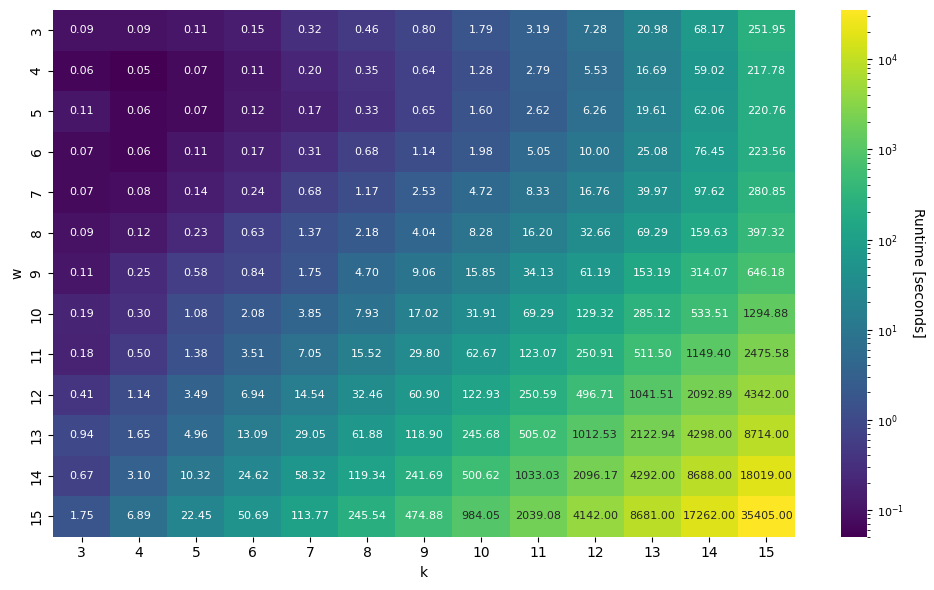

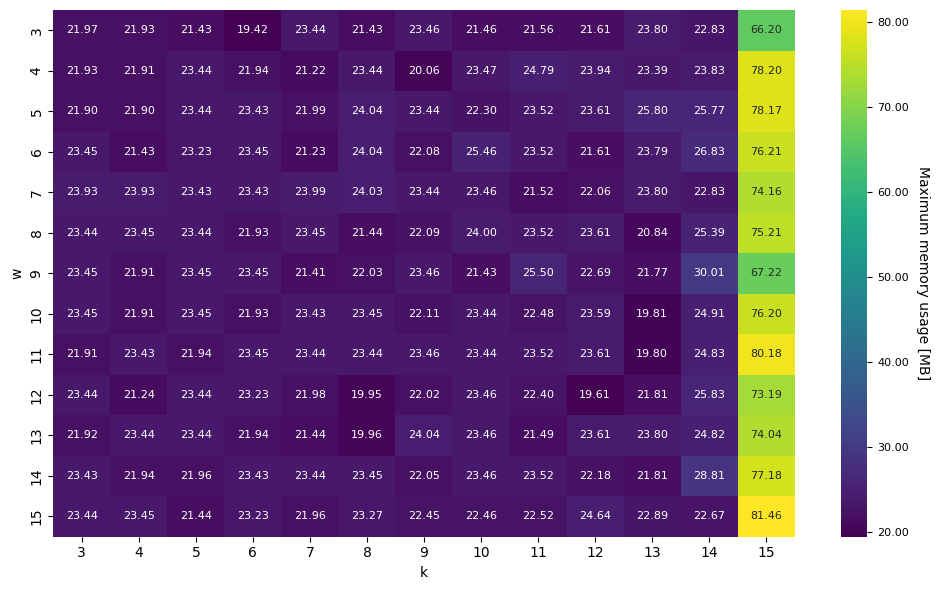

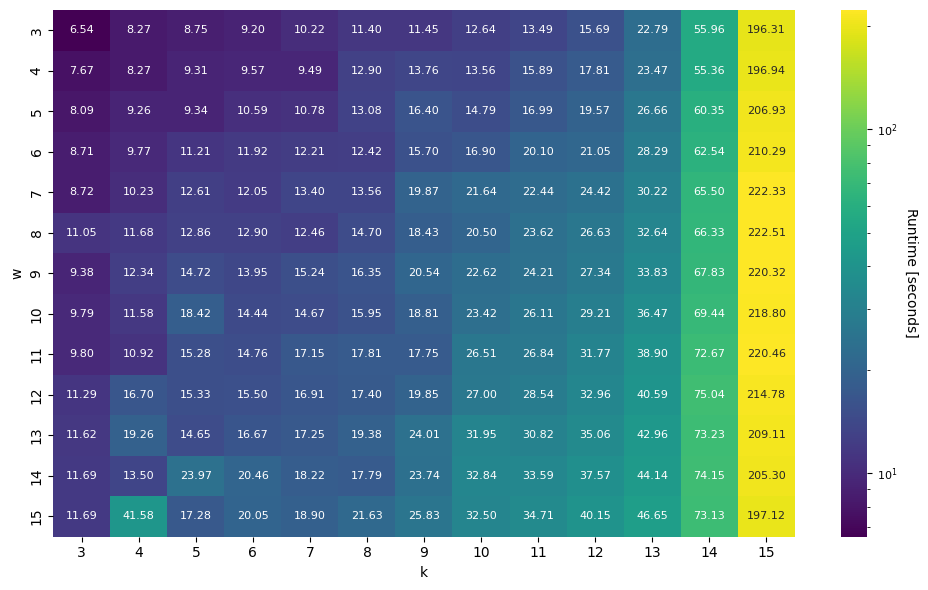

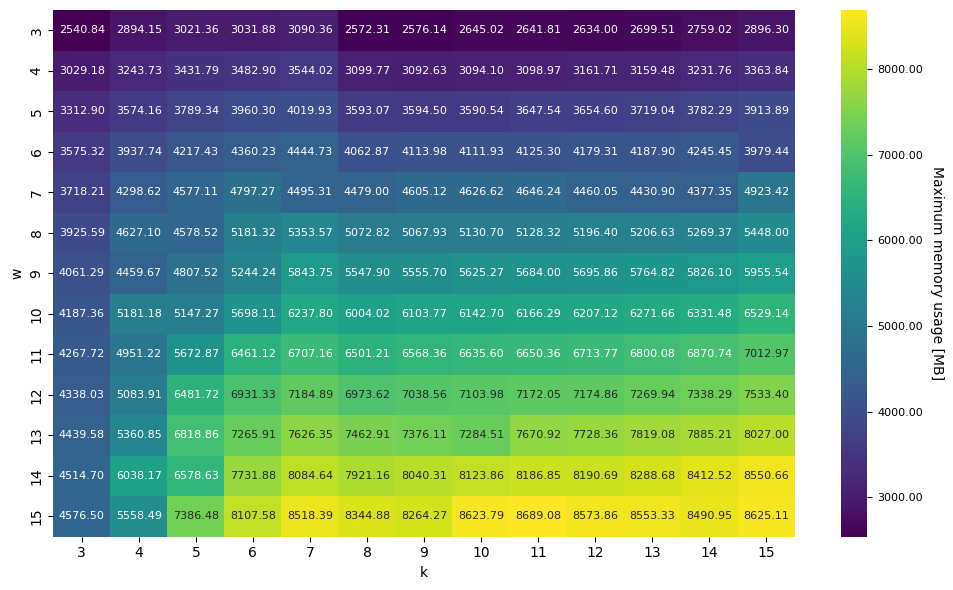

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm

# Function to format numbers normally with two decimal places
def format_normally(num):
    return f"{num:.2f}"

def plot_heatmap(dataframe, legend_name, log_scale=True, name='expected_runtime'):
    plt.figure(figsize=(10, 6))
    
    if log_scale:
        # Handle zeros and negative values by replacing them with a small positive number
        min_positive = dataframe[dataframe > 0].min().min()
        if pd.isnull(min_positive):
            min_positive = 1e-10  # Default small positive number if all values are zero or negative
        dataframe = dataframe.replace(0, min_positive / 10)
        dataframe = dataframe.clip(lower=min_positive / 10)
        
        # Create labels with normal formatting
        labels = dataframe.applymap(format_normally)
        
        # Get the min and max values for normalization
        vmin = dataframe.min().min()
        vmax = dataframe.max().max()
        
        # Create the heatmap with logarithmic normalization
        ax = sns.heatmap(
            dataframe,
            annot=labels,
            fmt="",
            cmap="viridis",
            norm=LogNorm(vmin=vmin, vmax=vmax),
            annot_kws={"size": 8}
        )
        
        # Customize the colorbar with logarithmic ticks
        cbar = ax.collections[0].colorbar
        exp_min = int(np.floor(np.log10(vmin)))
        exp_max = int(np.ceil(np.log10(vmax)))
        ticks = [10 ** exp for exp in range(exp_min + 1, exp_max)]
        cbar.set_ticks(ticks)
        
        # Formatter for the colorbar ticks in scientific notation
        def cbar_formatter(x, pos):
            if x == 0:
                return "0"
            exponent = int(np.log10(x))
            return r"$10^{{{}}}$".format(exponent)
        
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(cbar_formatter))
        cbar.ax.tick_params(labelsize=8)
    else:
        # For linear scale, ensure no negative values
        dataframe = dataframe.clip(lower=0)
        
        # Create labels with normal formatting
        labels = dataframe.applymap(format_normally)
        
        # Create the heatmap without normalization
        ax = sns.heatmap(
            dataframe,
            annot=labels,
            fmt="",
            cmap="viridis",
            annot_kws={"size": 8}
        )
        
        # Customize the colorbar with linear ticks
        cbar = ax.collections[0].colorbar
        
        # Formatter for the colorbar ticks in normal decimal format
        def cbar_formatter(x, pos):
            return f"{x:.2f}"
        
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(cbar_formatter))
        cbar.ax.tick_params(labelsize=8)
    
    # Add label to the colorbar
    cbar.set_label(legend_name, rotation=270, labelpad=15)
    
    plt.xlabel("k")
    plt.ylabel("w")
    plt.tight_layout()

    plt.savefig(f"{name}.pdf", dpi=500)

    plt.show()


# Example usage with your dataframes
plot_heatmap(time_df, "Runtime [seconds]", log_scale=True, name="expected_runtime") 
plot_heatmap(memory_df, "Maximum memory usage [MB]", log_scale=False, name="expected_memory")
plot_heatmap(time_df3, "Runtime [seconds]", log_scale=True, name="particular_runtime")  
plot_heatmap(memory_df3, "Maximum memory usage [MB]", log_scale=False, name="particular_memory")  


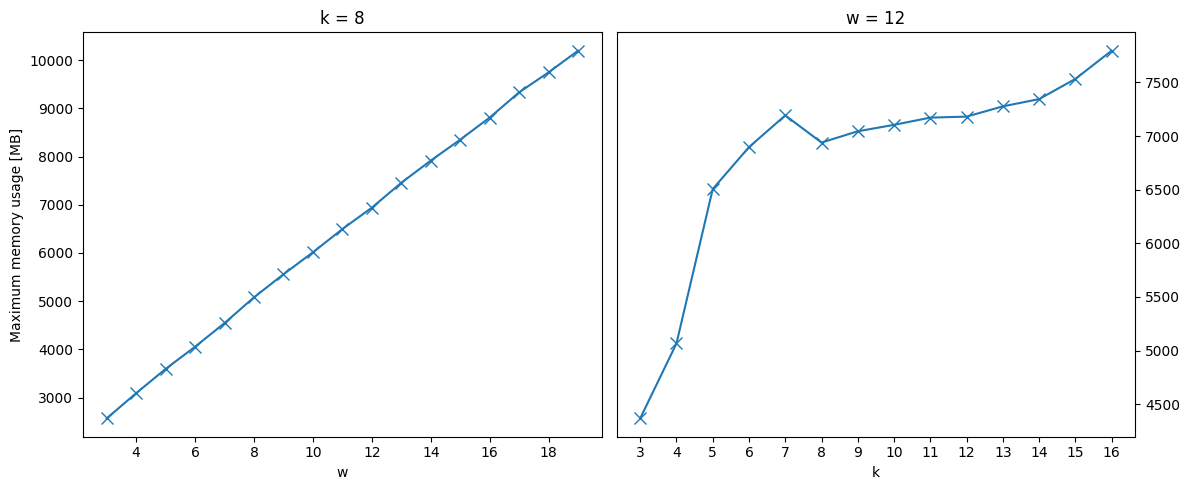

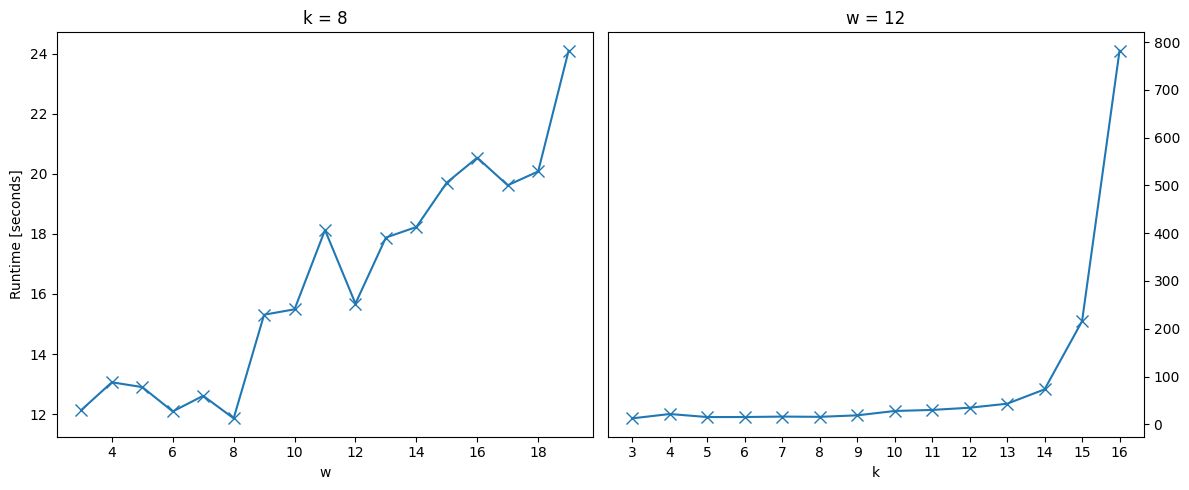

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# create the /figures directory if it does not exist
os.makedirs("figures", exist_ok=True)


# Function to plot memory usage side by side for fixed k and w values
def plot_memory_usage(time_df, memory_df, k_value, w_value):
    plt.figure(figsize=(12, 5))

    # Left plot: Memory usage for fixed k
    ax1 = plt.subplot(1, 2, 1)
    memory_series_k = memory_df[k_value].dropna()
    ax1.plot(memory_series_k.index, memory_series_k, marker='x', linestyle='-', markersize=8)
    ax1.set_xlabel("w")
    ax1.set_ylabel("Maximum memory usage [MB]")
    ax1.set_title(f"k = {k_value}")

    # Right plot: Memory usage for fixed w
    ax2 = plt.subplot(1, 2, 2)
    memory_series_w = memory_df.loc[w_value].dropna()
    ax2.plot(memory_series_w.index, memory_series_w, marker='x', linestyle='-', markersize=8)
    ax2.set_xlabel("k")
    ax2.set_title(f"w = {w_value}")

    # Set Y-axis ticks to the right, but no Y-axis title for the right plot
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    plt.tight_layout()
    plt.savefig("figures/10_memory_usage_particular.svg", dpi=500)
    plt.show()

# Function to plot runtime side by side for fixed k and w values
def plot_runtime(time_df, memory_df, k_value, w_value):
    plt.figure(figsize=(12, 5))

    # Left plot: Runtime for fixed k
    ax1 = plt.subplot(1, 2, 1)
    time_series_k = time_df[k_value].dropna()
    ax1.plot(time_series_k.index, time_series_k, marker='x', linestyle='-', markersize=8)
    ax1.set_xlabel("w")
    ax1.set_ylabel("Runtime [seconds]")
    ax1.set_title(f"k = {k_value}")

    # Right plot: Runtime for fixed w
    ax2 = plt.subplot(1, 2, 2)
    time_series_w = time_df.loc[w_value].dropna()
    ax2.plot(time_series_w.index, time_series_w, marker='x', linestyle='-', markersize=8)
    ax2.set_xlabel("k")
    ax2.set_title(f"w = {w_value}")

    # Set Y-axis ticks to the right, but no Y-axis title for the right plot
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    plt.tight_layout()
    plt.savefig("figures/9_runtime_paricular.svg", dpi=500)
    plt.show()

# Example Usage:
k_value_to_plot = '8'  # Replace with the k value you want to plot
w_value_to_plot = 12  # Replace with the w value you want to plot




# Plot memory usage side by side
plot_memory_usage(time_df2, memory_df2, k_value_to_plot, w_value_to_plot)

# Plot runtime side by side
plot_runtime(time_df2, memory_df2, k_value_to_plot, w_value_to_plot)


In [6]:
def log_file_to_swap_matrix(log_path, name):
    """
    Parses the log file to extract the number of swaps and total swap attempts
    for each (W, K) pair and returns them as Pandas DataFrames.

    Parameters:
    - log_path: str, path to the log file.
    - name: str, identifier name to append to the CSV filenames.

    Returns:
    - swaps_df: DataFrame, number of swaps for each (W, K).
    - total_swaps_df: DataFrame, total swap attempts for each (W, K).
    """

    # Regular expression pattern to capture W, K, swaps, and total_times
    pattern = (
        r"Running for W = (\d+) and K = (\d+).*?"
        r"Time limit reached, swapped (\d+) times out of (\d+) times"
    )

    # Dictionaries to store swaps and total swap attempts data
    swaps_data = {}
    total_swaps_data = {}

    # Read the log file
    with open(log_path, "r") as file:
        log_data = file.read()

    # Find all matches and parse the values
    matches = re.finditer(pattern, log_data, re.DOTALL)
    for match in matches:
        w = int(match.group(1))
        k = int(match.group(2))
        swaps = int(match.group(3))
        total_swaps = int(match.group(4))

        # Store the results in their respective dictionaries
        swaps_data[(w, k)] = swaps
        total_swaps_data[(w, k)] = total_swaps

    # Extract unique W and K values for creating the DataFrames
    ws = sorted(set(w for w, k in swaps_data))
    ks = sorted(set(k for w, k in swaps_data))

    # Create 2D DataFrames for swaps and total swap attempts
    swaps_df = pd.DataFrame(index=ws, columns=ks)
    total_swaps_df = pd.DataFrame(index=ws, columns=ks)

    # Populate the DataFrames with the extracted values
    for (w, k), swaps in swaps_data.items():
        swaps_df.loc[w, k] = swaps

    for (w, k), total_swaps in total_swaps_data.items():
        total_swaps_df.loc[w, k] = total_swaps

    # Add "W/K" in the corner by renaming the index and columns
    swaps_df.index.name = "W/K"
    total_swaps_df.index.name = "W/K"

    # Save the DataFrames to CSV files
    swaps_df.to_csv(f"swaps_data_{name}.csv")
    total_swaps_df.to_csv(f"total_swaps_data_{name}.csv")

    # Display the DataFrames
    print("Number of Swaps:")
    print(swaps_df)
    print("\nTotal Swap Attempts:")
    print(total_swaps_df)

    return swaps_df, total_swaps_df

# Example Usage
# Assuming you have log_path and log_path2 defined
swap_df_expected, total_swap_df_expected = log_file_to_swap_matrix(log_path, 'expected')


Number of Swaps:
        3      4      5       6       7       8       9        10       11  \
W/K                                                                          
3    34468  54004  84176  125465  227221  408100  713520  1509019  3055947   
4        0  27812  38808   77561  141570  262686  518543  1010735  2202207   
5        0  17012  22917   43241   63671  114872  237065   600814   915940   
6        0   9036  26659   45289   77966  212750  302510   584423  1448634   
7        0   5421  13559   31505   97874  148759  322553   212509  1005446   
8     5719   6477  13858   51033   56851  237951  398345   944780  1432458   
9     2322   5756  17289   19926   66097   88310  386991   554740  1451217   
10    2711   6106  11446   42947   94936  204064  560250  1131239  1997144   
11    1499   4027  10099   32602   58312  208650  361617   705562  1492509   
12    3248   3091  28346   40553   88377  220051  533191   986883  2194129   
13    1698   1636  14562   37213   67385  19617

In [7]:
# print total_swap_df_expected min and max
print(total_swap_df_expected.min().min())
print(total_swap_df_expected.max().max())

# print total_swap_df average and standard deviation
print(total_swap_df_expected.mean().mean())
print(total_swap_df_expected.std().std())

# print total_swap_df_expected median
print(total_swap_df_expected.median().median())


# print total_swap_df_expected number of elements below 1000 as a percentage
threshold=  10000
print((total_swap_df_expected < threshold).sum().sum() / total_swap_df_expected.size * 100)

6840
427802273
13905463.893491123
31718622.357666895
1047501.0
1.7751479289940828


In [8]:
# calculate min and max for each k
for k in total_swap_df_expected.columns:
    print(f"k={k}: min={total_swap_df_expected[k].min()}, max={total_swap_df_expected[k].max()}")

print("\n\n")
# do the same but divide by 2^k
for k in total_swap_df_expected.columns:
    print(f"k={k}: min={total_swap_df_expected[k].min() / 2**k}, max={total_swap_df_expected[k].max() / 2**k}")


print("\n\n")
# do the same but divide by 2^k
for k in total_swap_df_expected.columns:
    print(f"k={k}: min={total_swap_df_expected[k].min() / 2**k}")

k=3: min=6840, max=137929
k=4: min=19710, max=126026
k=5: min=42177, max=186455
k=6: min=80894, max=258535
k=7: min=138918, max=466571
k=8: min=211330, max=825793
k=9: min=488258, max=1722090
k=10: min=445442, max=3823424
k=11: min=1851373, max=6118477
k=12: min=1944702, max=13702388
k=13: min=8895330, max=37211995
k=14: min=19179559, max=122191557
k=15: min=40459757, max=427802273



k=3: min=855.0, max=17241.125
k=4: min=1231.875, max=7876.625
k=5: min=1318.03125, max=5826.71875
k=6: min=1263.96875, max=4039.609375
k=7: min=1085.296875, max=3645.0859375
k=8: min=825.5078125, max=3225.75390625
k=9: min=953.62890625, max=3363.45703125
k=10: min=435.001953125, max=3733.8125
k=11: min=903.99072265625, max=2987.53759765625
k=12: min=474.78076171875, max=3345.3095703125
k=13: min=1085.855712890625, max=4542.4798583984375
k=14: min=1170.6273803710938, max=7457.980773925781
k=15: min=1234.7337951660156, max=13055.489288330078



k=3: min=855.0
k=4: min=1231.875
k=5: min=1318.03125
k=6: min=1

In [9]:

# calculate min and max for each w
for w in total_swap_df_expected.index:
    print(f"w={w}: min={total_swap_df_expected.loc[w].min()}, max={total_swap_df_expected.loc[w].max()}")

w=3: min=126026, max=427802273
w=4: min=91449, max=277075193
w=5: min=56043, max=115360814
w=6: min=43465, max=98809762
w=7: min=22408, max=54899280
w=8: min=28461, max=54458340
w=9: min=14162, max=40459757
w=10: min=21514, max=59740166
w=11: min=8654, max=45357207
w=12: min=15841, max=52531895
w=13: min=10447, max=47082936
w=14: min=7762, max=79883105
w=15: min=6840, max=70033862
